# Klassifikation der in scikit-learn vektorisierten Daten (disciplines_only)

Autorin: Maria Hartmann

In [1]:
# Imports
import os
import time
import pandas as pd
import numpy as np
import scipy.sparse
from matplotlib import pyplot
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.neural_network import MLPClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


Einlesen der vektorisierten Daten

In [5]:
trainset_labels = '../Datasets/disciplines_only_train_idents_labels.csv' 
testset_labels = '../Datasets/disciplines_only_test_idents_labels.csv' 

trainset_csv = pd.read_csv(trainset_labels, delimiter=';')
y_train = trainset_csv['classes'].values
z_train = trainset_csv['url'].values
train_vectors = trainset_csv['filename'].values

testset_csv = pd.read_csv(testset_labels, delimiter=';')
y_test = testset_csv['classes'].values
z_test = testset_csv['url'].values
test_vectors = testset_csv['filename'].values

# Splitten der Labels pro Blogbeitrag
y_train = [e.split(', ') for e in y_train]
y_test = [e.split(', ') for e in y_test]

In [6]:
if len(set(train_vectors)) == 1:
    X_train = scipy.sparse.load_npz('../%s' % train_vectors[0])
else:
    print("Error with len(set(train_vectors))")
if len(set(test_vectors)) == 1:
    X_test = scipy.sparse.load_npz('../%s' % test_vectors[0])
else:
    print("Error with len(set(test_vectors))")

In [7]:
print(z_train[0])
print(y_train[0])
print(test_vectors[0])
print(X_train.shape)
X_train

archivewk1.hypotheses.org/2023
['histoire et archéologie_d']
Datasets/disciplines_only_test_scikit-learn_sparse_matrix.npz
(17080, 10000)


<17080x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2373689 stored elements in Compressed Sparse Row format>

In [8]:
dim = X_train.shape[1]
print(dim)

10000


In [9]:
output_dir = "../disciplines_only" 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

k-hot-Kodierung der Labels

In [10]:
# k-hot-encode labels mit MultiLabelBinarizer
label_encoder = MultiLabelBinarizer()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.transform(y_test)
print(encoded_y_train[0])

[0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [11]:
print(len(label_encoder.classes_))
for i, element in enumerate(label_encoder.classes_):
    print(i, element)

14
0 administration publique et développement_d
1 arts et humanités_d
2 bibliothéconomie_d
3 histoire et archéologie_d
4 langue et linguistique_d
5 littérature_d
6 pluridisciplinarité_d
7 psychologie_d
8 sciences de l'information et de la communication_d
9 sciences de la santé et de la santé publique_d
10 sciences politiques_d
11 sociologie et anthropologie_d
12 travail social et politique sociale_d
13 éducation_d


# Klassifikation mit MLPClassifier

In [ ]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(2048, 512), validation_fraction=0.1, early_stopping=True, verbose=True, random_state=1)
mlp_start = time.time()
mlp_clf = mlp_clf.fit(X_train, encoded_y_train)
mlp_time = (time.time() - mlp_start)/60

Iteration 1, loss = 3.16798568
Validation score: 0.617681
Iteration 2, loss = 1.34563578
Validation score: 0.697892


In [ ]:
print(mlp_time)
mlp_predicted = mlp_clf.predict(X_test)

In [ ]:
mlp_precision = precision_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_precision)
mlp_recall = recall_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_recall)
mlp_f1 = f1_score(encoded_y_test, mlp_predicted.round(), average='samples')
print(mlp_f1)

# Klassifikation mit Dense-Layer in Keras

In [28]:
# Keras model 

dense_model = Sequential()
dense_model.add(Dense(2048, input_dim=dim, activation="relu"))
dense_model.add(Dropout(0.4))
dense_model.add(Dense(512, activation="relu"))
dense_model.add(Dropout(0.4))
#dense_model.add(Flatten())
dense_model.add(Dense(len(label_encoder.classes_), activation="sigmoid"))

summary = dense_model.summary()
print("\n", summary)
config = dense_model.get_config()
print("\n", config)

# compile keras model
lossfunction = 'binary_crossentropy'
optimizer = "adam"
metrics = ['accuracy']

dense_model.compile(loss=lossfunction, 
              optimizer=optimizer,
              metrics=metrics)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=7, verbose=10),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=10),
                 ]

# train keras model
batch_size = 32
epochs = 100
dense_start = time.time()
dense_estimator = dense_model.fit(X_train,
                            np.array(encoded_y_train), 
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=10, 
                            validation_split=0.1,
                            shuffle=True
                           )

dense_time = (time.time() - dense_start)/60
print("Laufzeit in Minuten:", dense_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2048)              20482048  
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 35)                17955     
Total params: 21,549,091
Trainable params: 21,549,091
Non-trainable params: 0
_________________________________________________________________

 None

 [{'class_name': 'Dense', 'config': {'name': 'dense_14', 'trainable': True, 'batch_input_shape': (None, 10000), 'dtype': '

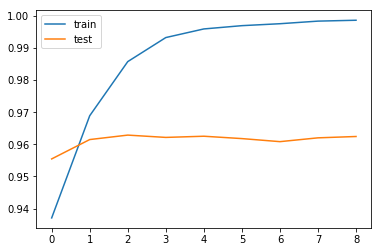

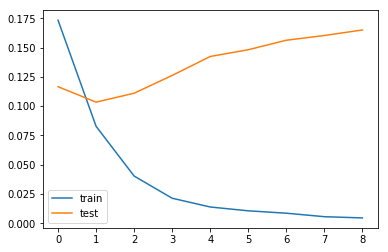

In [35]:
# visualize the train and validate loss and accuracy

# plot history for accuracy
pyplot.plot(estimator.history['acc'], label='train')
pyplot.plot(estimator.history['val_acc'], label='test')
pyplot.legend()
pyplot.savefig('%s/disciplines_only_dense_plot_acc.png' % output_dir)
pyplot.show()
pyplot.close()

# plot history for loss
pyplot.plot(estimator.history['loss'], label='train')
pyplot.plot(estimator.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('%s/disciplines_only_dense_plot_loss.png' % output_dir)
pyplot.show()
pyplot.close()

In [37]:
print(dense_time)
dense_predicted = model_keras.predict_proba(X_test)

23.570493078231813


In [39]:
print(dense_predicted[0].round())
print(encoded_y_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [40]:
dense_precision = precision_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_precision)
dense_recall = recall_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_recall)
dense_f1 = f1_score(encoded_y_test, dense_predicted.round(), average='samples')
print(dense_f1)

0.8642741193407393
0.8309326231661435
0.8376419175095027


c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
c:\users\hartmann\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# Klassifikation mit LSTM-Layer in Keras

In [ ]:
# LSTM in Keras
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=dim, output_dim=64))
lstm_model.add(LSTM(32, activation="relu"))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(len(label_encoder.classes_), activation="sigmoid"))

summary = lstm_model.summary()
print("\n", summary)
config = lstm_model.get_config()
print("\n", config)

# compile keras model
lossfunction = 'binary_crossentropy'
optimizer = "adam"
metrics = ['accuracy']

lstm_model.compile(loss=lossfunction,
                   optimizer=optimizer,
                   metrics=metrics)

callbacks_list = [EarlyStopping(monitor='val_loss', patience=7, verbose=10),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=10),
                 ]

# train keras model
batch_size = 32
epochs = 100
dense_start = time.time()
lstm_estimator = lstm_model.fit(X_train,
                            np.array(encoded_y_train), 
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=10, 
                            validation_split=0.1,
                            shuffle=True
                           )

lstm_time = (time.time() - lstm_start)/60
print("Laufzeit in Minuten:", lstm_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 1024)        10240000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               3147776   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 35)                17955     
Total params: 13,405,731
Trainable params: 13,405,731
Non-trainable params: 0
_________________________________________________________________

 None

 [{'class_name': 'Embedding', 'config': {'name': 'embedding_1', 'trainable': True, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 10000, 'output_dim': 1024, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval

In [ ]:
# visualize the train and validate loss and accuracy

# plot history for accuracy
pyplot.plot(lstm_estimator.history['acc'], label='train')
pyplot.plot(lstm_estimator.history['val_acc'], label='test')
pyplot.legend()
pyplot.savefig('%s/disciplines_only_lstm_plot_acc.png' % output_dir)
pyplot.show()
pyplot.close()

# plot history for loss
pyplot.plot(lstm_estimator.history['loss'], label='train')
pyplot.plot(lstm_estimator.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('%s/disciplines_only_lstm_plot_loss.png' % output_dir)
pyplot.show()
pyplot.close()

In [ ]:
print(lstm_time)
lstm_predicted = lstm_clf.predict_proba(X_test)

In [ ]:
lstm_precision = precision_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_precision)
lstm_recall = recall_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_recall)
lstm_f1 = f1_score(encoded_y_test, lstm_predicted.round(), average='samples')
print(lstm_f1)